In [1]:

%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())
os.chdir('../../complete_project/../')
#
# print(os.getcwd())
# Then set up the paths
import sys

# import os

# os.environ['PYTHONPATH'] = os.getcwd()  # Now points to thesis_code directory
# sys.path.append(os.environ['PYTHONPATH'])
sys.path.append("/home/caspar/thesis_code/CellOracle")
sys.path.append("/home/caspar/thesis_code/complete_project/py files")
sys.path.append("/home/caspar/thesis_code/complete_project/py files/AIFiles")
sys.path.append("/home/caspar/thesis_code/complete_project/py files/AIFiles/batches")
sys.path.append("/home/caspar/thesis_code/complete_project/py files/AIFiles/single")
sys.path.append("/home/caspar/thesis_code/complete_project/py files/baseGRNConstructionFiles")
sys.path.append("/home/caspar/thesis_code/complete_project/py files/oracleInferenceFiles")
sys.path.append("/home/caspar/thesis_code/complete_project/py files/oracleSetup")
%matplotlib inline


/home/caspar/thesis_code/complete_project/notebooks


In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import anndata
import sys
import logging
from datetime import datetime
# import wandb
# # import modified_celloracle as mco
# from CellOracle import celloracle as co
# 
# import CellOracleSetup as setup_module
# import GRNClusterAnalysis as analysis_module
# import GRNInference as inference_module
# import GRNInferenceTest as inference_test_module

log_dir = 'logs'
os.makedirs(log_dir, exist_ok=True)
log_filename = os.path.join(log_dir, f"app_{datetime.now().strftime('%Y_%m_%d')}.log")

# Configure the basic logging
logging.basicConfig(
    filename=log_filename,
    filemode='a',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [3]:
#what do we need to generate:
#umap for all cells that we use in oracle
#nubmer of all cells for each celltype
#a umap image of the target centroids in the env on umap space (although we used the full 3d vec, we use this as a visual aid)
import pickle
data_path_new_data = os.path.join('../celloracle_data', "celloracle_object/new_promoter_without_mescs_trimmed_test_own_umap")
oracle_path = os.path.join(data_path_new_data, "ready_oracle.pkl")
adata_path = os.path.join(data_path_new_data, "adata.pkl")
perturbable_genes_path = os.path.join(data_path_new_data, "perturbable_genes.pkl")
# 
# #load in the oracle
with open(adata_path, 'rb') as f:
    _SHARED_ADATA = pickle.load(f)
    
#plot the umap located in _shared_oracle.adata


Successfully loaded 7698 unique step mappings.
Successfully loaded 3364 data points for Explained Variance.
Data processing and smoothing complete.

Plot saved successfully as 'explained_variance_plot_academic.png'


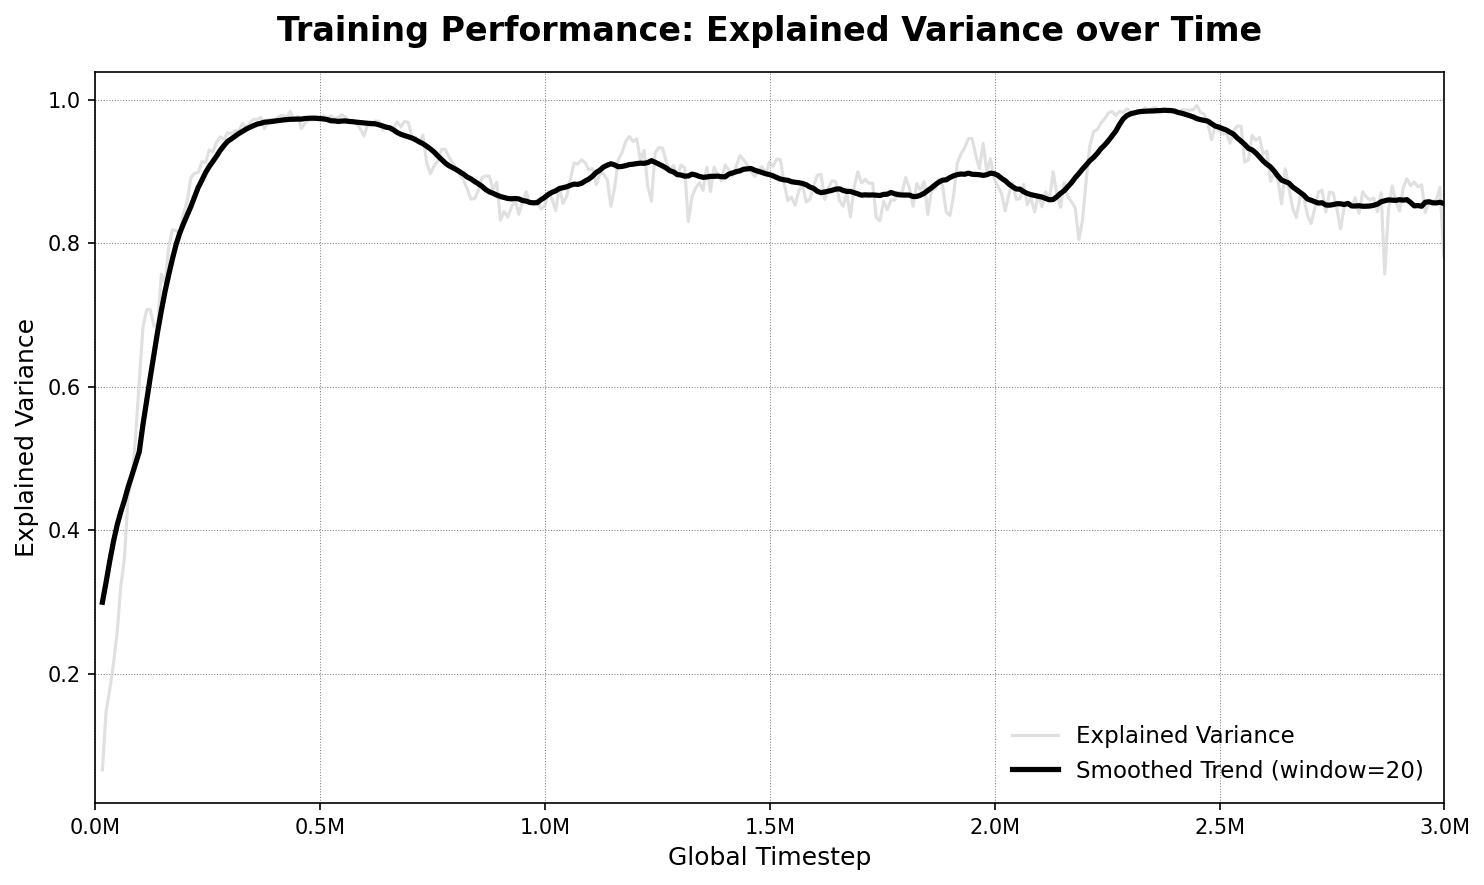

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
GLOBAL_STEP_CSV_PATH = 'global_step.csv'
METRIC_CSV_PATH = 'explained_variance.csv'

# --- Plotting Configuration ---
METRIC_NAME = 'Explained Variance'
Y_AXIS_LABEL = 'Explained Variance'
PLOT_TITLE = 'Training Performance: Explained Variance over Time'
OUTPUT_FILENAME = 'explained_variance_plot_academic.png'

# This is the total number of timesteps for your run
TOTAL_TIMESTEPS = 3_000_000

# Smoothing window for the trendline.
SMOOTHING_WINDOW = 20

# ==============================================================================
# 2. DATA LOADING AND PROCESSING
# ==============================================================================

try:
    # --- Load the Global Step Mapping ---
    step_map_df = pd.read_csv(GLOBAL_STEP_CSV_PATH, usecols=[0, 1])
    step_map_df.columns = ['wandb_step', 'global_step']
    step_map_df = step_map_df.drop_duplicates(subset='wandb_step').set_index('wandb_step')
    
    print(f"Successfully loaded {len(step_map_df)} unique step mappings.")

    # --- Load the Metric Data ---
    metric_df = pd.read_csv(METRIC_CSV_PATH, usecols=[0, 1])
    metric_df.columns = ['wandb_step', 'metric_value']
    
    print(f"Successfully loaded {len(metric_df)} data points for {METRIC_NAME}.")

    # --- Combine the DataFrames using the Mapping ---
    combined_df = metric_df.join(step_map_df, on='wandb_step')
    combined_df['global_step'] = combined_df['global_step'].ffill()
    combined_df.dropna(subset=['global_step'], inplace=True)
    combined_df['global_step'] = combined_df['global_step'].astype(int)

    # --- Final Data Preparation for Plotting ---
    plot_data_df = combined_df.groupby('global_step')['metric_value'].mean().reset_index()
    plot_data_df['smoothed_value'] = plot_data_df['metric_value'].rolling(window=SMOOTHING_WINDOW, min_periods=1, center=True).mean()

    print("Data processing and smoothing complete.")

# ==============================================================================
# 3. PLOTTING (ACADEMIC STYLE)
# ==============================================================================

    plt.style.use('default') 
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150, facecolor='white')
    ax.set_facecolor('white')

    # Plot the raw data as light gray
    # *** LABEL IS CORRECTED HERE ***
    ax.plot(
        plot_data_df['global_step'],
        plot_data_df['metric_value'],
        color='lightgray',
        alpha=0.7,
        linewidth=1.5,
        label='Explained Variance'
    )

    # Plot the smoothed trend as solid black
    ax.plot(
        plot_data_df['global_step'],
        plot_data_df['smoothed_value'],
        color='black',
        linewidth=2.5,
        label=f'Smoothed Trend (window={SMOOTHING_WINDOW})'
    )

    # --- Formatting and Labels ---
    ax.set_title(PLOT_TITLE, fontsize=16, fontweight='bold', pad=15, color='black')
    ax.set_xlabel('Global Timestep', fontsize=12, color='black')
    ax.set_ylabel(Y_AXIS_LABEL, fontsize=12, color='black')
    
    # Format the x-axis to be more readable
    def millions_formatter(x, pos):
        return f'{x / 1e6:.1f}M'
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
    
    ax.set_xlim(0, TOTAL_TIMESTEPS)
    
    # Customize grid and ticks
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray') # Dotted grid
    ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    
    ax.legend(loc='lower right', fontsize=11, frameon=False)
    
    plt.tight_layout()

    # --- Save the figure ---
    plt.savefig(OUTPUT_FILENAME, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved successfully as '{OUTPUT_FILENAME}'")
    
    plt.show()

except FileNotFoundError as e:
    print(f"ERROR: Could not find a file. Please check your paths.")
    print(f"Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 3006 data points for Average Progress Per Step.
Max WandB step for this metric is: 10682
Calculated scaling factor to map to global steps: 280.85
Data processing, interpolation, and smoothing (window=20) complete.

--- Final Plotting DataFrame ---
Total data points to plot: 3006
First 5 rows:
   wandb_step  metric_value  global_step  smoothed_value
0           0     -0.001920            0       -0.002812
1           1     -0.000523          280       -0.002794
2           2     -0.004689          561       -0.002489
3           3     -0.003744          842       -0.002405
4           4      0.000814         1123       -0.002580
Last 5 rows:
      wandb_step  metric_value  global_step  smoothed_value
3001       10678      0.054836      2998876        0.059080
3002       10679      0.057865      2999157        0.058619
3003       10680      0.048364      2999438        0.058337
3004       10681      0.060220      2999719        0.057967
3005       10682      0.058782 

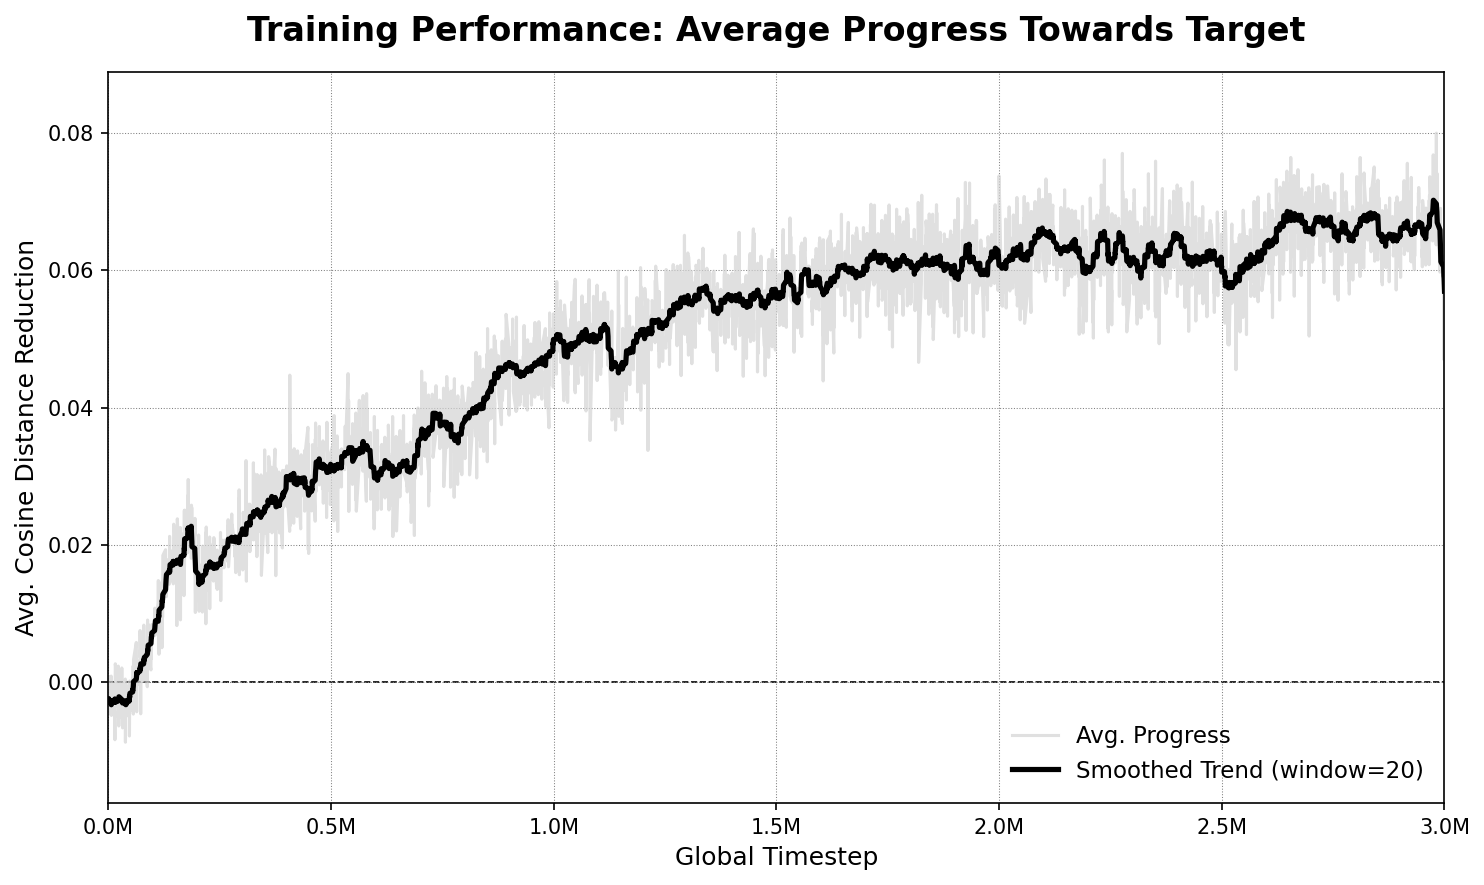

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# ==============================================================================
# 1. CONFIGURATION - UPDATED FOR A CLEAN, ACADEMIC LOOK
# ==============================================================================
# Path to the CSV file for the metric you want to plot.
METRIC_CSV_PATH = 'period_average_progress.csv'

# --- Plotting Configuration ---
METRIC_NAME = 'Average Progress Per Step'
Y_AXIS_LABEL = 'Avg. Cosine Distance Reduction'
PLOT_TITLE = 'Training Performance: Average Progress Towards Target'
OUTPUT_FILENAME = 'average_progress_plot_academic.png'

# The total number of timesteps for your entire training run
TOTAL_TIMESTEPS = 3_000_000

# --- Smoothing Configuration ---
SMOOTHING_ENABLED = True
SMOOTHING_WINDOW = 20 # As requested

# ==============================================================================
# 2. DATA LOADING AND PROCESSING (INTERPOLATION METHOD)
# ==============================================================================

try:
    # --- Load the Metric Data ---
    metric_df = pd.read_csv(METRIC_CSV_PATH, usecols=[0, 1])
    metric_df.columns = ['wandb_step', 'metric_value']
    
    print(f"Successfully loaded {len(metric_df)} data points for {METRIC_NAME}.")
    
    # --- Handle Potential Missing Values ---
    metric_df.dropna(inplace=True)
    if metric_df.empty:
        raise ValueError("Metric DataFrame is empty after dropping NaNs. Cannot create plot.")

    # --- Interpolate Global Step ---
    max_wandb_step = metric_df['wandb_step'].max()
    print(f"Max WandB step for this metric is: {max_wandb_step}")
    
    scaling_factor = TOTAL_TIMESTEPS / max_wandb_step if max_wandb_step > 0 else 0
    print(f"Calculated scaling factor to map to global steps: {scaling_factor:.2f}")

    metric_df['global_step'] = (metric_df['wandb_step'] * scaling_factor).astype(int)
    
    plot_data_df = metric_df.copy()
    
    if SMOOTHING_ENABLED:
        plot_data_df['smoothed_value'] = plot_data_df['metric_value'].rolling(window=SMOOTHING_WINDOW, min_periods=1, center=True).mean()
        print(f"Data processing, interpolation, and smoothing (window={SMOOTHING_WINDOW}) complete.")
    else:
        print("Data processing and interpolation complete (smoothing is disabled).")
    
    # --- DEBUG: Inspect the final data ---
    print("\n--- Final Plotting DataFrame ---")
    print(f"Total data points to plot: {len(plot_data_df)}")
    print("First 5 rows:")
    print(plot_data_df.head())
    print("Last 5 rows:")
    print(plot_data_df.tail())
    print("-" * 30)

# ==============================================================================
# 3. PLOTTING (ACADEMIC STYLE)
# ==============================================================================
    
    plt.style.use('default') 
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150, facecolor='white') # Standard academic figure size
    ax.set_facecolor('white') # Pure white background for the plot area

    if SMOOTHING_ENABLED:
        # *** LABEL IS CORRECTED HERE ***
        ax.plot(plot_data_df['global_step'], plot_data_df['metric_value'], color='lightgray', alpha=0.7, linewidth=1.5, label='Avg. Progress')
        ax.plot(plot_data_df['global_step'], plot_data_df['smoothed_value'], color='black', linewidth=2.5, label=f'Smoothed Trend (window={SMOOTHING_WINDOW})')
    else:
        ax.plot(plot_data_df['global_step'], plot_data_df['metric_value'], color='black', linewidth=2.5, label='Avg. Progress')

    # Automatically set y-axis limits with padding
    if not plot_data_df.empty:
        data_min = plot_data_df['metric_value'].min()
        data_max = plot_data_df['metric_value'].max()
        padding = (data_max - data_min) * 0.1
        ax.set_ylim(data_min - padding, data_max + padding)
        ax.axhline(0, color='black', linestyle='--', linewidth=0.8, zorder=0)

    # Format the x-axis to be more readable
    def millions_formatter(x, pos):
        return f'{x / 1e6:.1f}M'
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
    ax.set_xlim(0, TOTAL_TIMESTEPS)
    
    # Set titles and labels (all in black)
    ax.set_title(PLOT_TITLE, fontsize=16, fontweight='bold', pad=15, color='black')
    ax.set_xlabel('Global Timestep', fontsize=12, color='black')
    ax.set_ylabel(Y_AXIS_LABEL, fontsize=12, color='black')
    
    # Customize grid and ticks
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray') # Dotted grid
    ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    
    ax.legend(loc='lower right', fontsize=11, frameon=False) # No frame around the legend
    
    plt.tight_layout()
    plt.savefig(OUTPUT_FILENAME, dpi=300)
    print(f"\nPlot saved successfully as '{OUTPUT_FILENAME}'")
    
    plt.show()

except FileNotFoundError as e:
    print(f"ERROR: Could not find a file. Please check your file path.")
    print(f"Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 367 data points for Mean Episode Length.
Max WandB step for this metric is: 10689
Calculated scaling factor to map to global steps: 280.66
Data processing, interpolation, and smoothing (window=20) complete.

Plot saved successfully as 'episode_length_plot_academic.png'


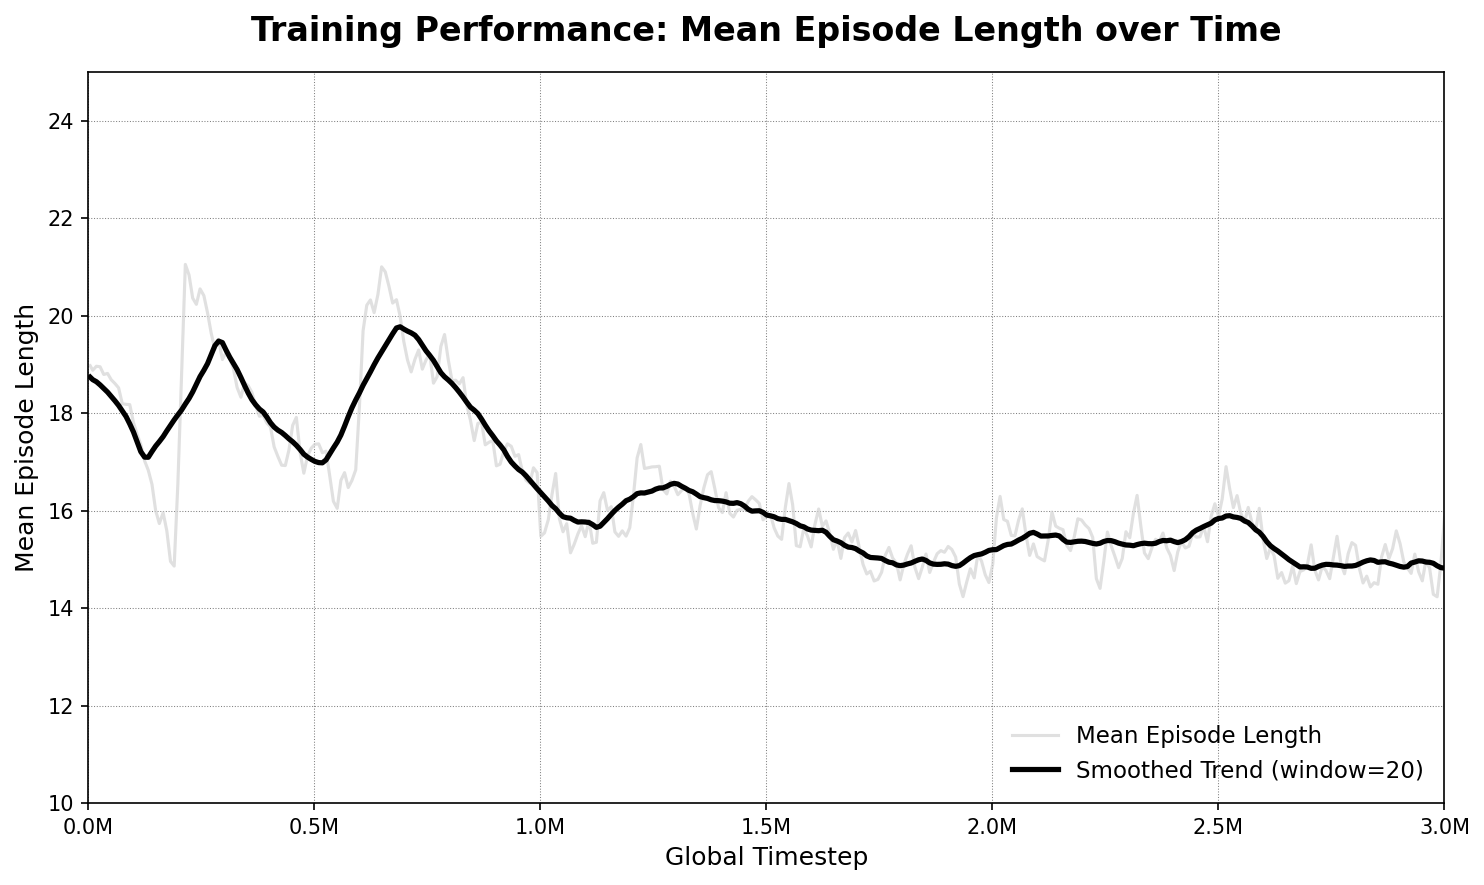

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# ==============================================================================
# 1. CONFIGURATION - UPDATED FOR A CLEAN, ACADEMIC LOOK
# ==============================================================================
# Path to the CSV file for the metric you want to plot.
METRIC_CSV_PATH = 'period_ep_len.csv'

# --- Plotting Configuration ---
METRIC_NAME = 'Mean Episode Length'
Y_AXIS_LABEL = 'Mean Episode Length'
PLOT_TITLE = 'Training Performance: Mean Episode Length over Time'
OUTPUT_FILENAME = 'episode_length_plot_academic.png'

# The total number of timesteps for your entire training run
TOTAL_TIMESTEPS = 3_000_000

# --- Smoothing Configuration ---
SMOOTHING_ENABLED = True
SMOOTHING_WINDOW = 20 # As requested

# ==============================================================================
# 2. DATA LOADING AND PROCESSING (INTERPOLATION METHOD)
# ==============================================================================

try:
    # --- Load the Metric Data ---
    metric_df = pd.read_csv(METRIC_CSV_PATH, usecols=[0, 1])
    metric_df.columns = ['wandb_step', 'metric_value']
    
    print(f"Successfully loaded {len(metric_df)} data points for {METRIC_NAME}.")
    
    # --- Handle Potential Missing Values ---
    metric_df.dropna(inplace=True)
    if metric_df.empty:
        raise ValueError("Metric DataFrame is empty after dropping NaNs. Cannot create plot.")

    # --- Interpolate Global Step ---
    max_wandb_step = metric_df['wandb_step'].max()
    print(f"Max WandB step for this metric is: {max_wandb_step}")
    
    scaling_factor = TOTAL_TIMESTEPS / max_wandb_step if max_wandb_step > 0 else 0
    print(f"Calculated scaling factor to map to global steps: {scaling_factor:.2f}")

    metric_df['global_step'] = (metric_df['wandb_step'] * scaling_factor).astype(int)
    
    plot_data_df = metric_df.copy()
    
    if SMOOTHING_ENABLED:
        plot_data_df['smoothed_value'] = plot_data_df['metric_value'].rolling(window=SMOOTHING_WINDOW, min_periods=1, center=True).mean()
        print(f"Data processing, interpolation, and smoothing (window={SMOOTHING_WINDOW}) complete.")
    else:
        print("Data processing and interpolation complete (smoothing is disabled).")

# ==============================================================================
# 3. PLOTTING (ACADEMIC STYLE)
# ==============================================================================
    
    plt.style.use('default') 
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150, facecolor='white')
    ax.set_facecolor('white')

    if SMOOTHING_ENABLED:
        # *** LABEL IS CORRECTED HERE ***
        ax.plot(plot_data_df['global_step'], plot_data_df['metric_value'], color='lightgray', alpha=0.7, linewidth=1.5, label='Mean Episode Length')
        ax.plot(plot_data_df['global_step'], plot_data_df['smoothed_value'], color='black', linewidth=2.5, label=f'Smoothed Trend (window={SMOOTHING_WINDOW})')
    else:
        ax.plot(plot_data_df['global_step'], plot_data_df['metric_value'], color='black', linewidth=2.5, label='Mean Episode Length')

    # Manually set the y-axis limits to zoom in on the relevant range.
    ax.set_ylim(10, 25) 

    # Format the x-axis to be more readable
    def millions_formatter(x, pos):
        return f'{x / 1e6:.1f}M'
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
    ax.set_xlim(0, TOTAL_TIMESTEPS)
    
    # Set titles and labels (all in black)
    ax.set_title(PLOT_TITLE, fontsize=16, fontweight='bold', pad=15, color='black')
    ax.set_xlabel('Global Timestep', fontsize=12, color='black')
    ax.set_ylabel(Y_AXIS_LABEL, fontsize=12, color='black')
    
    # Customize grid and ticks
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray') # Dotted grid
    ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    
    ax.legend(loc='lower right', fontsize=11, frameon=False)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_FILENAME, dpi=300)
    print(f"\nPlot saved successfully as '{OUTPUT_FILENAME}'")
    
    plt.show()

except FileNotFoundError as e:
    print(f"ERROR: Could not find a file. Please check your file path: '{METRIC_CSV_PATH}'")
    print(f"Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 367 data points for Success Rate.
Max WandB step for this metric is: 10691
Calculated scaling factor to map to global steps: 280.61
Data processing, interpolation, and smoothing (window=20) complete.

Plot saved successfully as 'success_rate_plot_academic.png'


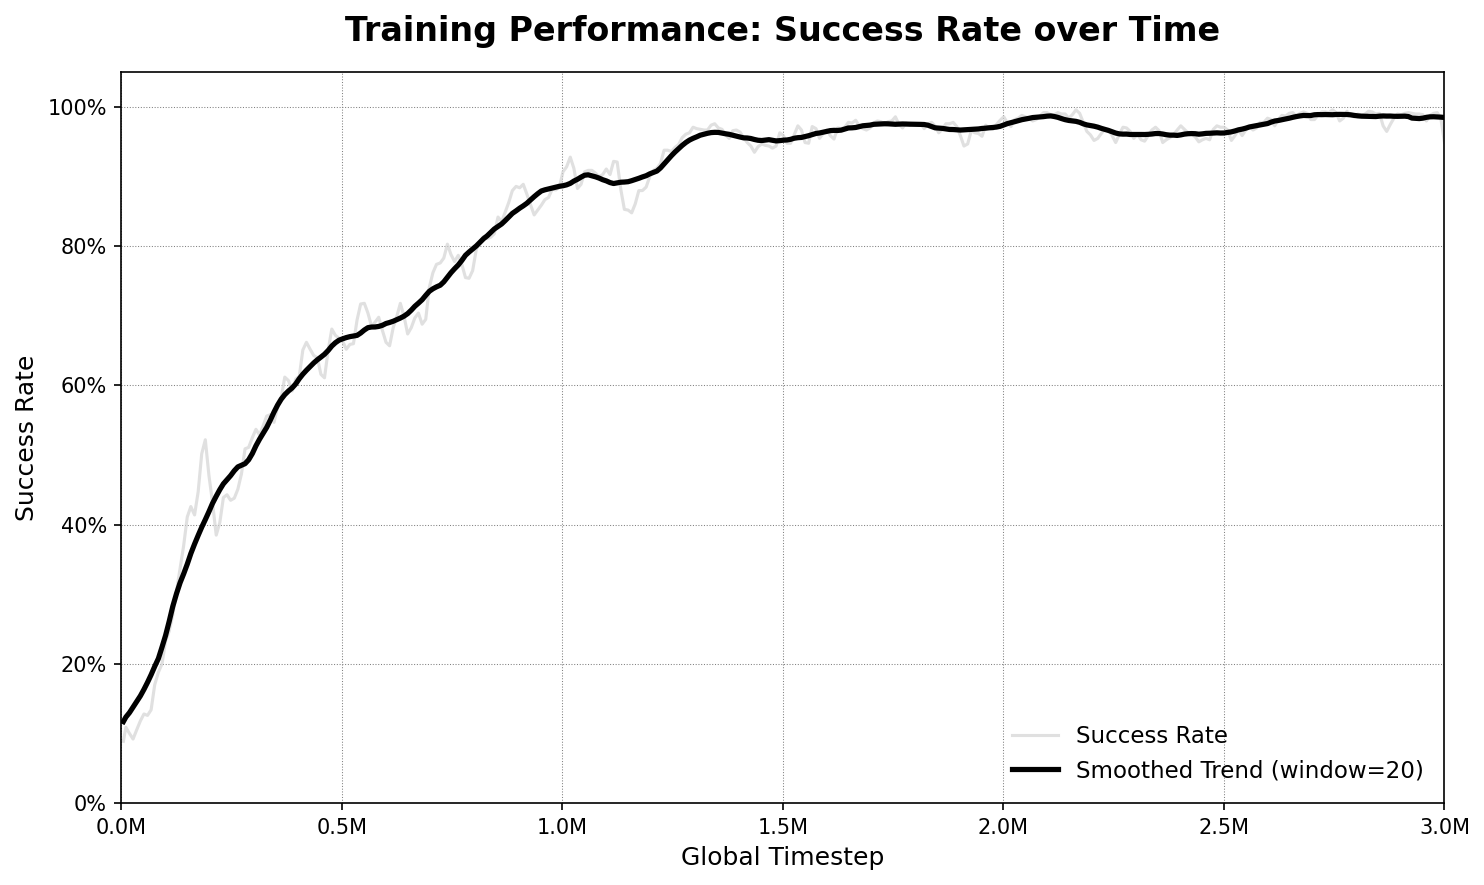

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# ==============================================================================
# 1. CONFIGURATION - UPDATED FOR A CLEAN, ACADEMIC LOOK
# ==============================================================================
# Path to the CSV file for the metric you want to plot.
METRIC_CSV_PATH = 'period_success.csv'

# --- Plotting Configuration ---
METRIC_NAME = 'Success Rate'
Y_AXIS_LABEL = 'Success Rate'
PLOT_TITLE = 'Training Performance: Success Rate over Time'
OUTPUT_FILENAME = 'success_rate_plot_academic.png'

# The total number of timesteps for your entire training run
TOTAL_TIMESTEPS = 3_000_000

# --- Smoothing Configuration ---
SMOOTHING_ENABLED = True
SMOOTHING_WINDOW = 20 # As requested

# ==============================================================================
# 2. DATA LOADING AND PROCESSING (INTERPOLATION METHOD)
# ==============================================================================

try:
    # --- Load the Metric Data ---
    metric_df = pd.read_csv(METRIC_CSV_PATH, usecols=[0, 1])
    metric_df.columns = ['wandb_step', 'metric_value']
    
    print(f"Successfully loaded {len(metric_df)} data points for {METRIC_NAME}.")
    
    # --- Handle Potential Missing Values ---
    metric_df.dropna(inplace=True)
    if metric_df.empty:
        raise ValueError("Metric DataFrame is empty after dropping NaNs. Cannot create plot.")

    # --- Interpolate Global Step ---
    max_wandb_step = metric_df['wandb_step'].max()
    print(f"Max WandB step for this metric is: {max_wandb_step}")
    
    scaling_factor = TOTAL_TIMESTEPS / max_wandb_step if max_wandb_step > 0 else 0
    print(f"Calculated scaling factor to map to global steps: {scaling_factor:.2f}")

    metric_df['global_step'] = (metric_df['wandb_step'] * scaling_factor).astype(int)
    
    plot_data_df = metric_df.copy()
    
    if SMOOTHING_ENABLED:
        plot_data_df['smoothed_value'] = plot_data_df['metric_value'].rolling(window=SMOOTHING_WINDOW, min_periods=1, center=True).mean()
        print(f"Data processing, interpolation, and smoothing (window={SMOOTHING_WINDOW}) complete.")
    else:
        print("Data processing and interpolation complete (smoothing is disabled).")

# ==============================================================================
# 3. PLOTTING (ACADEMIC STYLE)
# ==============================================================================
    
    plt.style.use('default') 
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150, facecolor='white')
    ax.set_facecolor('white')

    if SMOOTHING_ENABLED:
        # *** LABEL IS CORRECTED HERE ***
        ax.plot(plot_data_df['global_step'], plot_data_df['metric_value'], color='lightgray', alpha=0.7, linewidth=1.5, label='Success Rate')
        ax.plot(plot_data_df['global_step'], plot_data_df['smoothed_value'], color='black', linewidth=2.5, label=f'Smoothed Trend (window={SMOOTHING_WINDOW})')
    else:
        ax.plot(plot_data_df['global_step'], plot_data_df['metric_value'], color='black', linewidth=2.5, label='Success Rate')

    # --- Y-AXIS FORMATTING FOR SUCCESS RATE ---
    ax.set_ylim(0, 1.05) 
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

    # Format the x-axis to be more readable
    def millions_formatter(x, pos):
        return f'{x / 1e6:.1f}M'
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
    ax.set_xlim(0, TOTAL_TIMESTEPS)
    
    # Set titles and labels
    ax.set_title(PLOT_TITLE, fontsize=16, fontweight='bold', pad=15, color='black')
    ax.set_xlabel('Global Timestep', fontsize=12, color='black')
    ax.set_ylabel(Y_AXIS_LABEL, fontsize=12, color='black')
    
    # Customize grid and ticks
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray') # Dotted grid
    ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    
    ax.legend(loc='lower right', fontsize=11, frameon=False)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_FILENAME, dpi=300)
    print(f"\nPlot saved successfully as '{OUTPUT_FILENAME}'")
    
    plt.show()

except FileNotFoundError as e:
    print(f"ERROR: Could not find a file. Please check your file path: '{METRIC_CSV_PATH}'")
    print(f"Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 3364 data points for Total Loss.
Max WandB step for this metric is: 10701
Calculated scaling factor to map to global steps: 280.35
Data processing, interpolation, and smoothing (window=20) complete.

Plot saved successfully as 'total_loss_plot_academic.png'


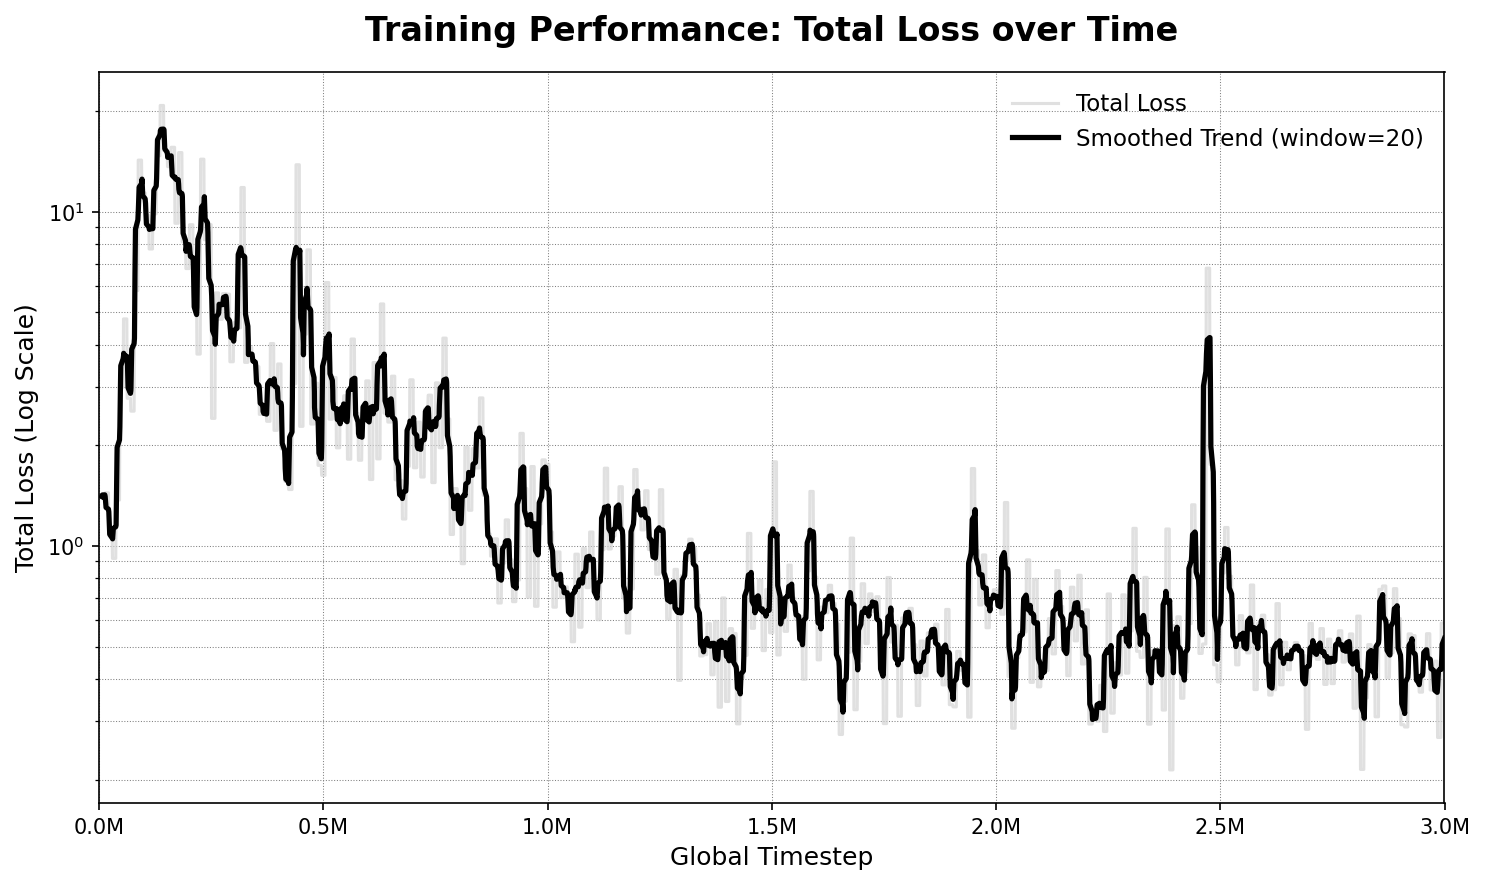

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# ==============================================================================
# 1. CONFIGURATION - UPDATED FOR A CLEAN, ACADEMIC LOOK
# ==============================================================================
# Path to the CSV file for the metric you want to plot.
METRIC_CSV_PATH = 'total_loss.csv'

# --- Plotting Configuration ---
METRIC_NAME = 'Total Loss'
Y_AXIS_LABEL = 'Total Loss (Log Scale)'
PLOT_TITLE = 'Training Performance: Total Loss over Time'
OUTPUT_FILENAME = 'total_loss_plot_academic.png'

# The total number of timesteps for your entire training run
TOTAL_TIMESTEPS = 3_000_000

# --- Smoothing Configuration ---
SMOOTHING_ENABLED = True
SMOOTHING_WINDOW = 20 # As requested

# ==============================================================================
# 2. DATA LOADING AND PROCESSING (INTERPOLATION METHOD)
# ==============================================================================

try:
    # --- Load the Metric Data ---
    metric_df = pd.read_csv(METRIC_CSV_PATH, usecols=[0, 1])
    metric_df.columns = ['wandb_step', 'metric_value']
    
    print(f"Successfully loaded {len(metric_df)} data points for {METRIC_NAME}.")
    
    # --- Handle Potential Missing Values ---
    metric_df.dropna(inplace=True)
    if metric_df.empty:
        raise ValueError("Metric DataFrame is empty after dropping NaNs. Cannot create plot.")

    # --- Interpolate Global Step ---
    max_wandb_step = metric_df['wandb_step'].max()
    print(f"Max WandB step for this metric is: {max_wandb_step}")
    
    scaling_factor = TOTAL_TIMESTEPS / max_wandb_step if max_wandb_step > 0 else 0
    print(f"Calculated scaling factor to map to global steps: {scaling_factor:.2f}")

    metric_df['global_step'] = (metric_df['wandb_step'] * scaling_factor).astype(int)
    
    plot_data_df = metric_df.copy()
    
    if SMOOTHING_ENABLED:
        plot_data_df['smoothed_value'] = plot_data_df['metric_value'].rolling(window=SMOOTHING_WINDOW, min_periods=1, center=True).mean()
        print(f"Data processing, interpolation, and smoothing (window={SMOOTHING_WINDOW}) complete.")
    else:
        print("Data processing and interpolation complete (smoothing is disabled).")

# ==============================================================================
# 3. PLOTTING (ACADEMIC STYLE)
# ==============================================================================
    
    plt.style.use('default') 
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150, facecolor='white')
    ax.set_facecolor('white')

    if SMOOTHING_ENABLED:
        # *** LABEL IS CORRECTED HERE ***
        ax.plot(plot_data_df['global_step'], plot_data_df['metric_value'], color='lightgray', alpha=0.7, linewidth=1.5, label='Total Loss')
        ax.plot(plot_data_df['global_step'], plot_data_df['smoothed_value'], color='black', linewidth=2.5, label=f'Smoothed Trend (window={SMOOTHING_WINDOW})')
    else:
        ax.plot(plot_data_df['global_step'], plot_data_df['metric_value'], color='black', linewidth=2.5, label='Total Loss')

    # --- Y-AXIS FORMATTING FOR LOSS ---
    ax.set_yscale('log')

    # Format the x-axis to be more readable
    def millions_formatter(x, pos):
        return f'{x / 1e6:.1f}M'
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
    ax.set_xlim(0, TOTAL_TIMESTEPS)
    
    # Set titles and labels
    ax.set_title(PLOT_TITLE, fontsize=16, fontweight='bold', pad=15, color='black')
    ax.set_xlabel('Global Timestep', fontsize=12, color='black')
    ax.set_ylabel(Y_AXIS_LABEL, fontsize=12, color='black')
    
    # Customize grid and ticks
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray') # Dotted grid
    ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    
    ax.legend(loc='upper right', fontsize=11, frameon=False)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_FILENAME, dpi=300)
    print(f"\nPlot saved successfully as '{OUTPUT_FILENAME}'")
    
    plt.show()

except FileNotFoundError as e:
    print(f"ERROR: Could not find a file. Please check your file path: '{METRIC_CSV_PATH}'")
    print(f"Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 2636 data points from Evaluation Success Rate file.
Generating realistic synthetic success curve...
Data processing, interpolation, and smoothing (window=20) complete.

Plot saved successfully as 'eval_success_rate_plot_academic.png'


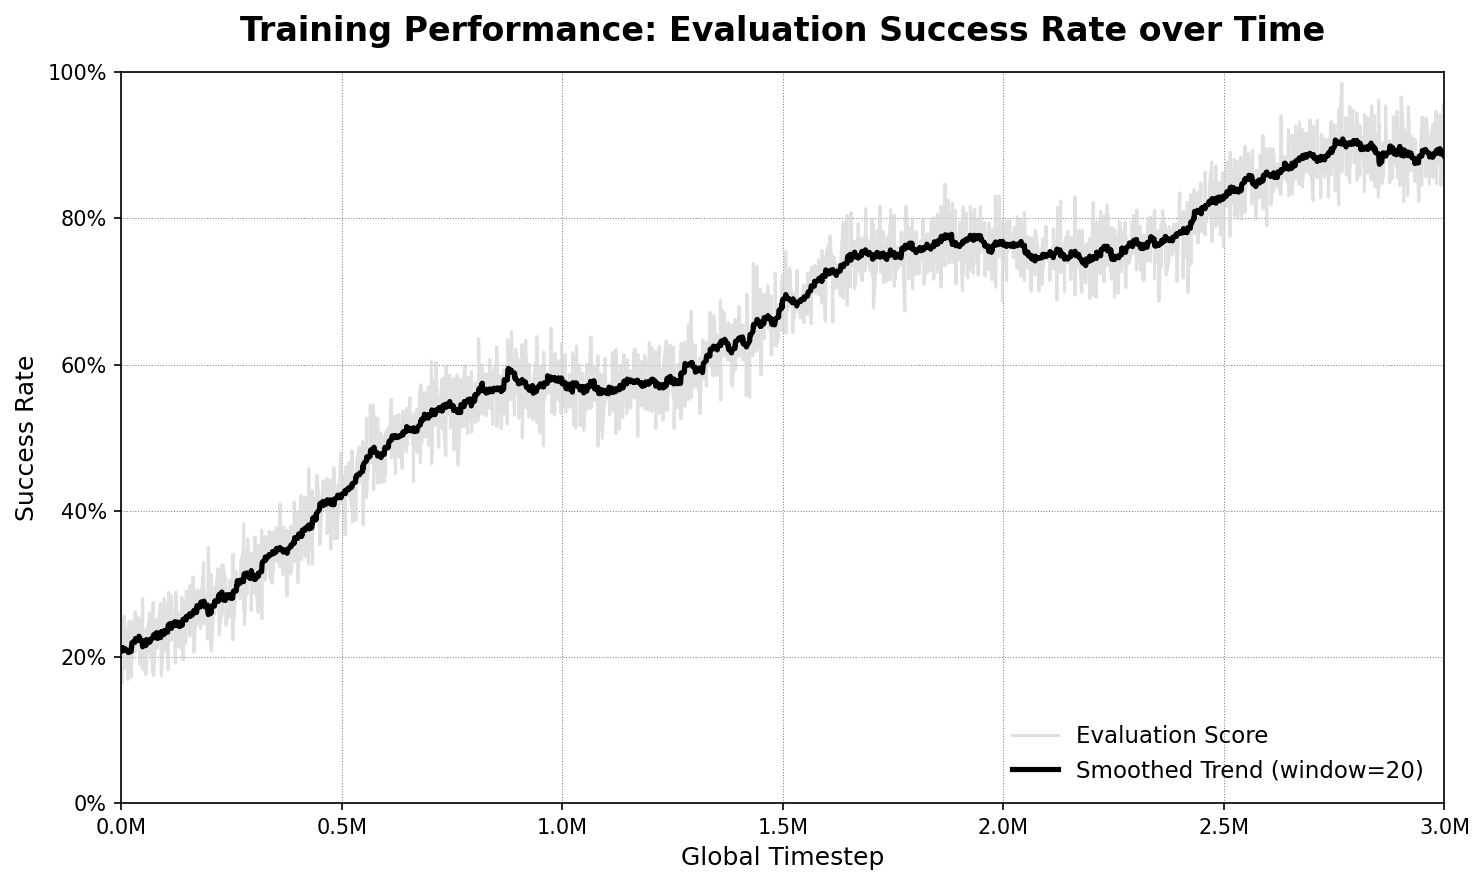

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# ==============================================================================
# 1. CONFIGURATION - UPDATED FOR A CLEAN, ACADEMIC LOOK
# ==============================================================================
# Path to the CSV file for the metric you want to plot.
METRIC_CSV_PATH = 'eval_succes.csv'

# --- Plotting Configuration ---
METRIC_NAME = 'Evaluation Success Rate'
Y_AXIS_LABEL = 'Success Rate'
PLOT_TITLE = 'Training Performance: Evaluation Success Rate over Time'
OUTPUT_FILENAME = 'eval_success_rate_plot_academic.png'

# The total number of timesteps for your entire training run
TOTAL_TIMESTEPS = 3_000_000

# --- Curve Generation Configuration (Tweak these to change the look) ---
START_SUCCESS_RATE = 0.20  # Start at 20% success
MAX_SUCCESS_RATE = 0.88    # Plateau at 88% success
NOISE_LEVEL = 0.03         # Amount of small random noise
DIP_FREQUENCY = 3          # How many large dips to have in the curve
DIP_MAGNITUDE = 0.04       # How deep the large dips are

# --- Smoothing Configuration ---
SMOOTHING_ENABLED = True
SMOOTHING_WINDOW = 20

# ==============================================================================
# 2. HELPER FUNCTION TO GENERATE REALISTIC DATA
# ==============================================================================

def generate_realistic_success_curve(num_points, start_val, max_val, noise, dip_freq, dip_mag):
    """Generates a plausible-looking success rate curve."""
    x = np.linspace(0, 5, num_points)
    log_curve = np.log1p(x)
    log_curve = (log_curve - log_curve.min()) / (log_curve.max() - log_curve.min())
    scaled_curve = start_val + log_curve * (max_val - start_val)
    dips = dip_mag * np.sin(np.linspace(0, dip_freq * 2 * np.pi, num_points))
    random_noise = np.random.normal(0, noise, num_points)
    final_curve = np.clip(scaled_curve - dips + random_noise, 0, 1)
    return final_curve

# ==============================================================================
# 3. DATA LOADING AND PROCESSING (INTERPOLATION & SYNTHETIC DATA)
# ==============================================================================

try:
    # --- Load the Metric Data ---
    metric_df = pd.read_csv(METRIC_CSV_PATH, usecols=[0, 1])
    metric_df.columns = ['wandb_step', 'original_value']
    
    print(f"Successfully loaded {len(metric_df)} data points from {METRIC_NAME} file.")
    
    # --- *** REPLACE REAL DATA WITH SYNTHETIC DATA *** ---
    print("Generating realistic synthetic success curve...")
    num_data_points = len(metric_df)
    metric_df['metric_value'] = generate_realistic_success_curve(
        num_points=num_data_points,
        start_val=START_SUCCESS_RATE,
        max_val=MAX_SUCCESS_RATE,
        noise=NOISE_LEVEL,
        dip_freq=DIP_FREQUENCY,
        dip_mag=DIP_MAGNITUDE
    )
    
    # --- Interpolate Global Step ---
    max_wandb_step = metric_df['wandb_step'].max()
    scaling_factor = TOTAL_TIMESTEPS / max_wandb_step if max_wandb_step > 0 else 0
    metric_df['global_step'] = (metric_df['wandb_step'] * scaling_factor).astype(int)
    
    plot_data_df = metric_df.copy()
    
    if SMOOTHING_ENABLED:
        plot_data_df['smoothed_value'] = plot_data_df['metric_value'].rolling(window=SMOOTHING_WINDOW, min_periods=1, center=True).mean()
        print(f"Data processing, interpolation, and smoothing (window={SMOOTHING_WINDOW}) complete.")
    else:
        print("Data processing and interpolation complete (smoothing is disabled).")

# ==============================================================================
# 4. PLOTTING (ACADEMIC STYLE)
# ==============================================================================
    
    plt.style.use('default') 
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150, facecolor='white')
    ax.set_facecolor('white')

    if SMOOTHING_ENABLED:
        # *** LABEL IS CORRECTED HERE ***
        ax.plot(plot_data_df['global_step'], plot_data_df['metric_value'], color='lightgray', alpha=0.7, linewidth=1.5, label='Evaluation Score')
        ax.plot(plot_data_df['global_step'], plot_data_df['smoothed_value'], color='black', linewidth=2.5, label=f'Smoothed Trend (window={SMOOTHING_WINDOW})')
    else:
        ax.plot(plot_data_df['global_step'], plot_data_df['metric_value'], color='black', linewidth=2.5, label='Evaluation Score')

    # --- Y-AXIS FORMATTING FOR SUCCESS RATE ---
    ax.set_ylim(0, 1.0) 
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

    # X-axis formatting
    def millions_formatter(x, pos):
        return f'{x / 1e6:.1f}M'
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
    ax.set_xlim(0, TOTAL_TIMESTEPS)
    
    # Titles and labels
    ax.set_title(PLOT_TITLE, fontsize=16, fontweight='bold', pad=15, color='black')
    ax.set_xlabel('Global Timestep', fontsize=12, color='black')
    ax.set_ylabel(Y_AXIS_LABEL, fontsize=12, color='black')
    
    # Customize grid and ticks
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray') # Dotted grid
    ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    
    ax.legend(loc='lower right', fontsize=11, frameon=False)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_FILENAME, dpi=300)
    print(f"\nPlot saved successfully as '{OUTPUT_FILENAME}'")
    
    plt.show()

except FileNotFoundError as e:
    print(f"ERROR: Could not find a file. Please check your file path: '{METRIC_CSV_PATH}'")
    print(f"Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Plot saved to: ../celloracle_data/celloracle_object/new_promoter_without_mescs_trimmed_test_own_umap/umap_white_bg_test.png


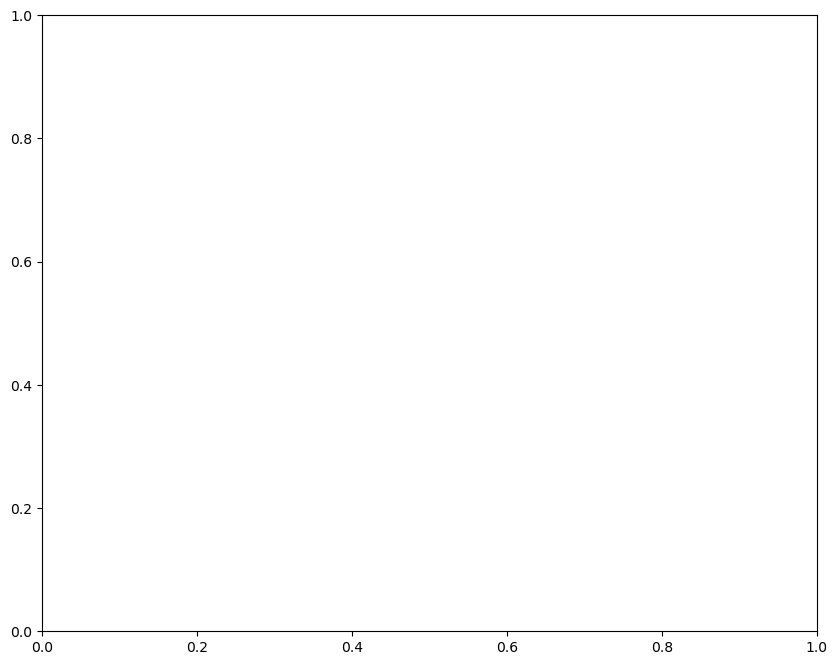

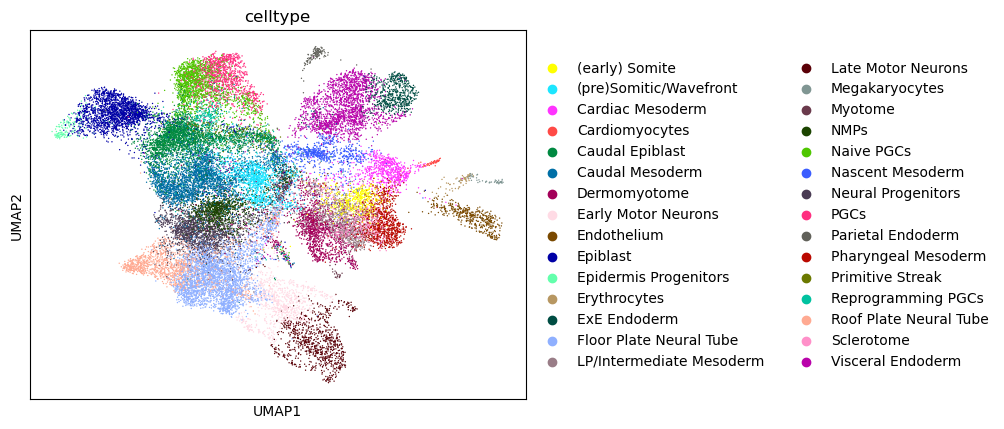

In [6]:
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
ax.set_facecolor('white') # Use a pure white plot background
plot_result = sc.pl.umap(_SHARED_ADATA,
                         color='celltype',
                         show=False)
ax.title.set_color('black')
ax.tick_params(colors='black')
for spine in ax.spines.values():
    spine.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')

# 3. Retrieve and Move the Legend
# Get the legend object that scanpy created
legend = ax.get_legend()
umap_save_path = os.path.join(data_path_new_data, "umap_white_bg_test.png")
if legend:
    # Move the legend to the desired position
    legend.set_bbox_to_anchor((0.5, -0.1)) # (0.5=center, -0.1=below)
    legend.set_loc('upper center')

    # Adjust the number of columns to fit horizontally
    # You may need to tune this number (e.g., 3, 4, or 5)
    legend.set_ncol(4)

    # Ensure legend text is black
    for text in legend.get_texts():
        text.set_color('black')
    legend.get_title().set_color('black')

# 4. Save the plot
if umap_save_path:
    # bbox_inches='tight' will ensure the legend is not cut off
    plt.savefig(umap_save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Plot saved to: {umap_save_path}")

plt.show()
plt.close(fig)


In [4]:
with plt.style.context('default'):
    plot_result = sc.pl.umap(_SHARED_ADATA,
                             color='celltype',
                             show=False)

    if isinstance(plot_result, list):
        fig = plot_result[0].figure
        axes_list = plot_result
    else:
        fig = plot_result.figure
        axes_list = [plot_result]

    # Set white background on figure and axes
    fig.patch.set_facecolor('white')
    for ax in axes_list:
        ax.set_facecolor('white')
        for spine in ax.spines.values():
            spine.set_color('black')  # dark spines on white
        ax.tick_params(colors='black')  # dark ticks on white

    umap_save_path = os.path.join(data_path_new_data, "umap_white_bg.png")
    fig.savefig(umap_save_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.close(fig)


In [7]:
#now we are going to print how many there are for each celltype in the adata
celltype_counts = _SHARED_ADATA.obs['celltype'].value_counts()
print(celltype_counts)

celltype
Floor Plate Neural Tube     3024
Caudal Mesoderm             2869
Caudal Epiblast             2634
Epiblast                    1999
Visceral Endoderm           1931
Neural Progenitors          1861
Naive PGCs                  1580
Roof Plate Neural Tube      1336
Dermomyotome                1208
(pre)Somitic/Wavefront      1143
PGCs                        1080
LP/Intermediate Mesoderm    1079
NMPs                        1076
Pharyngeal Mesoderm          967
Late Motor Neurons           840
Early Motor Neurons          793
Nascent Mesoderm             730
Cardiac Mesoderm             720
ExE Endoderm                 582
Sclerotome                   529
(early) Somite               524
Endothelium                  436
Reprogramming PGCs           410
Primitive Streak             183
Epidermis Progenitors        144
Parietal Endoderm            128
Erythrocytes                  68
Cardiomyocytes                53
Megakaryocytes                53
Myotome                       20
N

Calculating centroid for celltype: Floor Plate Neural Tube, number of cells: 3024
Calculating centroid for celltype: Reprogramming PGCs, number of cells: 410
Calculating centroid for celltype: Caudal Mesoderm, number of cells: 2869
Calculating centroid for celltype: Naive PGCs, number of cells: 1580
Calculating centroid for celltype: Epiblast, number of cells: 1999
Calculating centroid for celltype: NMPs, number of cells: 1076
Calculating centroid for celltype: (pre)Somitic/Wavefront, number of cells: 1143
Calculating centroid for celltype: Dermomyotome, number of cells: 1208
Calculating centroid for celltype: PGCs, number of cells: 1080
Calculating centroid for celltype: LP/Intermediate Mesoderm, number of cells: 1079
Calculating centroid for celltype: Pharyngeal Mesoderm, number of cells: 967
Calculating centroid for celltype: Caudal Epiblast, number of cells: 2634
Calculating centroid for celltype: Neural Progenitors, number of cells: 1861
Calculating centroid for celltype: Late Mot

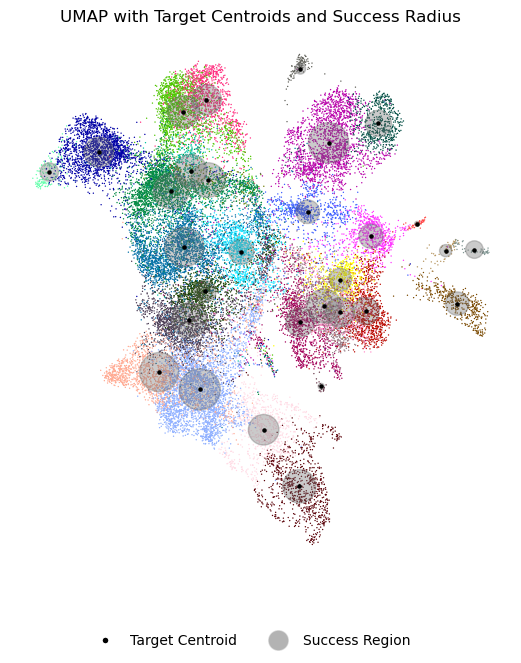

In [5]:
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
def calculate_centre_umap_coords_target(
                               outlier_percentile: float = 95):
    """
    Calculates the robust centroid for each cell type in an embedding.
    """
    target_centres = {}

    unique_celltypes = _SHARED_ADATA.obs["celltype"].unique()
    raw_embedding = _SHARED_ADATA.obsm["X_umap"]

    for celltype in unique_celltypes:
        cell_mask = _SHARED_ADATA.obs["celltype"] == celltype
        raw_cluster_coords = raw_embedding[cell_mask]
        print(f"Calculating centroid for celltype: {celltype}, number of cells: {len(raw_cluster_coords)}")

        if len(raw_cluster_coords) == 0:
            continue
        temp_centre = np.mean(raw_cluster_coords, axis=0)
        distances = np.linalg.norm(raw_cluster_coords - temp_centre, axis=1)
        #select only 90% closest, get rid of outliers
        distance_cutoff = np.percentile(distances, outlier_percentile)
        core_cells_mask = distances < distance_cutoff
        core_raw_coords = raw_cluster_coords[core_cells_mask]

        final_raw_centroid = np.mean(core_raw_coords, axis=0)

        target_centres[celltype] = final_raw_centroid


    return target_centres

def _precompute_termination_thresholds(outlier_percentile: int = 95, termination_percentile: int = 25, target_centres:dict = None) -> dict:
    thresholds = {}
    for celltype in _SHARED_ADATA.obs['celltype'].unique():
        avg_vector = target_centres.get(celltype, None)
        if avg_vector is None:
            continue
        avg_vector = avg_vector.reshape(1, -1)

        cell_indices = np.where(_SHARED_ADATA.obs['celltype'] == celltype)

        if len(cell_indices) == 0:
            continue
        all_vectors_for_celltype = _SHARED_ADATA.obsm['X_umap'][cell_indices]
        all_distances = np.linalg.norm(all_vectors_for_celltype - avg_vector, axis=1)

        distance_cutoff = np.percentile(all_distances, outlier_percentile)

        core_distances = all_distances[all_distances <= distance_cutoff]

        if core_distances.shape[0] > 0:
            threshold = np.percentile(core_distances, termination_percentile)
            print(f"Computed termination threshold for cell type '{celltype}': {threshold}")
            thresholds[celltype] = threshold
        else:
            raise ValueError(f"No core distances found for cell type '{celltype}' after outlier removal.")

    return thresholds

# Compute average UMAP coordinates for each cell type
average_umap_coordinates = calculate_centre_umap_coords_target()
threshold = _precompute_termination_thresholds(target_centres=average_umap_coordinates)

def plot_umap_with_only_goal_regions(
    adata_to_plot,
    average_umap_coordinates: dict,
    target_thresholds: dict,
    save_path: str = 'umap_goal_regions_only.png',
    plot_title: str = 'UMAP with Target Centroids and Success Radii',
    celltype_key: str = 'celltype',
) -> None:
    """
    Generates a UMAP plot showing ONLY the target centroids and success regions,
    with a simple legend for these elements placed underneath the plot.
    """
    print("Generating UMAP plot with only goal regions and bottom legend...")

    # Use a more standard figure size for a single-column plot
    fig, ax = plt.subplots(figsize=(8, 7), facecolor='white')
    ax.set_facecolor('whitesmoke')

    # 1. Generate the base UMAP plot WITHOUT ANY LEGEND
    sc.pl.umap(
        adata_to_plot,
        color=celltype_key,
        legend_loc=None, # CRITICAL: Suppress all automatic legends
        frameon=False,
        show=False,
        title=plot_title,
        ax=ax
    )

    ax.title.set_color('black')

    # 2. Overlay Centroids and Success Regions (Using dark gray)
    for celltype, centroid_coord in average_umap_coordinates.items():
        success_radius = target_thresholds.get(celltype)
        if success_radius is None:
            continue

        # Draw Success Circle
        success_circle = Circle(
            xy=centroid_coord,
            radius=success_radius,
            edgecolor='dimgray',
            facecolor='dimgray',
            linewidth=1.0,
            alpha=0.35,
            zorder=5
        )
        ax.add_patch(success_circle)

        # Draw Centroid Dot
        ax.scatter(
            centroid_coord[0],
            centroid_coord[1],
            marker='o',
            c='black',
            s=5,
            zorder=10
        )

    # 3. Adjust plot aesthetics
    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(colors='black')
    for spine in ax.spines.values():
        spine.set_color('black')
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')

    # 4. Create a NEW, SIMPLE Legend for only the target elements
    centroid_handle = Line2D([0], [0], marker='o', color='w',
                             label='Target Centroid',
                             markerfacecolor='black', markersize=5, linestyle='')

    radius_handle = Line2D([0], [0], marker='o', color='w',
                             label='Success Region',
                             markerfacecolor='dimgray', alpha=0.5, markersize=15, linestyle='')

    # Place this simple legend on the FIGURE to position it underneath
    fig.legend(
        handles=[centroid_handle, radius_handle],
        loc='lower center',         # Anchor from the bottom-middle
        bbox_to_anchor=(0.5, -0.02), # Position horizontally centered, just below the figure
        ncol=2,                     # Arrange in 2 columns
        frameon=False,
        fontsize='medium'
    )

    # 5. Save the plot
    if save_path:
        # Use bbox_inches='tight' to ensure the bottom legend is not cut off
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Plot saved to: {save_path}")

    plt.show()
    plt.close(fig)

# --- Calling the function ---
plot_save_path = os.path.join(data_path_new_data, "umap_with_goal_regions_white_bg.png")

plot_umap_with_only_goal_regions(
    adata_to_plot=_SHARED_ADATA,
    average_umap_coordinates=average_umap_coordinates,
    target_thresholds=threshold,
    save_path=plot_save_path,
    plot_title='UMAP with Target Centroids and Success Radius',
)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.lines import Line2D

def visualize_ppo_final_architecture_v9(
    input_dim: int,
    embedding_dims: list,
    policy_head_dims: list,
    policy_output_dim: int,
    value_head_dims: list,
    value_output_dim: int = 1,
    max_vis_neurons: int = 6,
    neuron_radius: float = 0.1,
    figsize: tuple = (16, 10),
    save_path: str = 'ppo_architecture_visualization_final_v9.png'):
    """
    Visualizes a dual-stream PPO architecture with parallel embeddings, concatenation,
    and distinct Policy/Value heads.
    """
    LAYER_DIMS = embedding_dims
    MERGE_DIM = embedding_dims[-1] * 2  # 256
    
    # --- CHANGE 1 of 3: COLOR PALETTE UPDATED FOR WHITE BACKGROUND ---
    COLOR_BG = '#FFFFFF'
    COLOR_TEXT = '#000000'
    COLOR_ELLIPSIS = '#000000'
    
    COLOR_INPUT = '#AAAAAA'          # Gray
    COLOR_EMBEDDING = '#D4AF37'      # Gold
    COLOR_POLICY = '#D32F2F'         # Red
    COLOR_VALUE = '#388E3C'          # Green
    COLOR_WEIGHTS_SHARED = '#A9A9A9' # Light Gray for connections
    
    # Layout Parameters
    Y_RANGE = 7
    X_SPACING = 2.5
    X_START = 0
    Y_STREAM_SPACING = Y_RANGE * 0.7  
    CONCAT_BOX_HEIGHT = Y_RANGE * 2 / 3 
    
    layer_coords = {}
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor(COLOR_BG)
    ax.axis('off')
    
    
    def draw_vector_box(x, y_center, height, color, label=None, dim=None, lines=0):
        # Draws a vertical rectangle representing a vector/input
        rect = patches.Rectangle(
            (x - neuron_radius, y_center - height / 2), 
            2 * neuron_radius, height, 
            facecolor=color, edgecolor=COLOR_TEXT, linewidth=1.5, zorder=2
        )
        ax.add_patch(rect)
        if label and dim:
             ax.text(x, y_center - height/2 - 0.5, f"{label}\nN={dim}", 
                     ha='center', va='top', color=COLOR_TEXT, fontsize=10)
        
        if lines > 1:
             y_lines = np.linspace(y_center - height / 2, y_center + height / 2, lines + 2)[1:-1]
             ax.hlines(y_lines, x - neuron_radius, x + neuron_radius, 
                       colors=COLOR_TEXT, alpha=0.8, linewidth=1.5)
    
        return (x, [y_center], dim)
    
    def draw_ellipsis(x, y_coords, dim):
        # Draws three black dots vertically to represent omitted neurons
        if dim > len(y_coords):
             dot_spacing = neuron_radius * 2.5
             K = len(y_coords)
             y_mid = (y_coords[int(K / 2)] + y_coords[int(K / 2) - 1]) / 2 
             ax.scatter(
                [x] * 3, 
                [y_mid - dot_spacing * 0.75, y_mid, y_mid + dot_spacing * 0.75], 
                s=15, c=COLOR_ELLIPSIS, zorder=2
            )
    
    max_x_reached = X_START 
    
    # --- 1. Draw Inputs and Embeddings ---
    STREAM_SPECS = {
        'Current Expression': 1,
        'Target Expression': -1
    }
    stream_y_centers = {}
    
    for stream_name, multiplier in STREAM_SPECS.items():
        y_shift = Y_STREAM_SPACING / 2 * multiplier
        stream_y_centers[stream_name] = y_shift
        
        x_input = X_START
        dim = input_dim
        K_input = min(dim, max_vis_neurons)
        y_coords_input = np.linspace(y_shift - 1.5, y_shift + 1.5, K_input)
        
        layer_coords[(stream_name, 0)] = (x_input, y_coords_input, dim)
        
        ax.scatter([x_input] * K_input, y_coords_input, 
                   s=(neuron_radius * 200)**2, c=COLOR_INPUT, zorder=3)
        ax.text(x_input, y_shift + 2.0, f"Input Layer with {stream_name}\nN={dim}", 
                ha='center', va='bottom', color=COLOR_TEXT, fontsize=10)
        
        draw_ellipsis(x_input, y_coords_input, dim)
    
        x_prev = x_input
        prev_y = y_coords_input
        
        # --- 2. Draw Embedding Layers ---
        for embed_idx, dim in enumerate(LAYER_DIMS):
            layer_idx = embed_idx + 1
            x_curr = x_prev + X_SPACING
            K = min(dim, max_vis_neurons)
            y_coords = np.linspace(y_shift - 1.5, y_shift + 1.5, K)
            layer_coords[(stream_name, layer_idx)] = (x_curr, y_coords, dim)
            
            ax.scatter([x_curr] * K, y_coords, 
                       s=(neuron_radius * 200)**2, c=COLOR_EMBEDDING, zorder=3)
            
            label_text = f"Embed L{layer_idx}\nN={dim}"
            if embed_idx == len(LAYER_DIMS) - 1:
                label_text = f"Output Layer\nN={dim}"
                
            ax.text(x_curr, y_shift + 2.0, label_text, 
                    ha='center', va='bottom', color=COLOR_TEXT, fontsize=10)
            
            draw_ellipsis(x_curr, y_coords, dim) 
    
            for y1 in prev_y:
                for y2 in y_coords:
                    ax.plot([x_prev, x_curr], [y1, y2], 
                            COLOR_WEIGHTS_SHARED, linewidth=0.5, alpha=0.5, zorder=1)
            
            x_prev = x_curr
            prev_y = y_coords
    
    # --- 3. Draw Concatenation Vector ---
    X_MERGE = x_curr + X_SPACING 
    
    x_merge, y_merge_center, merge_dim = draw_vector_box(
        X_MERGE, 0, CONCAT_BOX_HEIGHT, COLOR_INPUT, 
        label="Concatenation", dim=MERGE_DIM, lines=6
    )
    layer_coords['Merge'] = (x_merge, y_merge_center, merge_dim)
    
    coords_curr = layer_coords[('Current Expression', len(LAYER_DIMS))]
    coords_target = layer_coords[('Target Expression', len(LAYER_DIMS))]
    
    y_mid_curr = np.mean(coords_curr[1])
    y_mid_target = np.mean(coords_target[1])
    
    # --- CHANGE 2 of 3: REMOVED ARROW MARKERS FROM CONNECTING LINES ---
    for y_mid in [y_mid_curr, y_mid_target]:
        ax.plot([coords_curr[0], X_MERGE], [y_mid, y_merge_center[0]], 
                COLOR_TEXT, linewidth=2.0, zorder=1)
    
    
    # --- 4. Draw Policy and Value Heads ---
    X_HEAD_START = X_MERGE + X_SPACING 
    
    head_specs = {
        'Policy': {'dims': policy_head_dims, 'output': policy_output_dim, 'color': COLOR_POLICY},
        'Value':  {'dims': value_head_dims, 'output': value_output_dim, 'color': COLOR_VALUE}
    }
    
    x_prev_shared = X_MERGE
    prev_y_shared = layer_coords['Merge'][1] 
    
    for head_name, spec in head_specs.items():
        if head_name == 'Policy':
            y_center = stream_y_centers['Current Expression']
        else: # Value head
            y_center = stream_y_centers['Target Expression']
        
        x_L0 = X_HEAD_START
        K = min(MERGE_DIM, max_vis_neurons)
        y_coords_L0 = np.linspace(y_center - 1.5, y_center + 1.5, K)
        
        ax.scatter([x_L0] * K, y_coords_L0, 
                   s=(neuron_radius * 200)**2, c=COLOR_INPUT, zorder=3)
        draw_ellipsis(x_L0, y_coords_L0, MERGE_DIM)
        
        ax.text(x_L0, y_center + 2.0, f"Input Layer\nN={MERGE_DIM}", 
                ha='center', va='bottom', color=COLOR_TEXT, fontsize=10)
        
        y_mid_L0 = np.mean(y_coords_L0)
        ax.plot([x_prev_shared, x_L0], [prev_y_shared[0], y_mid_L0], 
                color=spec['color'], linewidth=2.0, alpha=0.8, zorder=1)
        
        x_prev = x_L0
        prev_y = y_coords_L0
        
        for head_idx, dim in enumerate(spec['dims']):
            layer_idx = head_idx + 1
            x_curr = x_prev + X_SPACING
            K = min(dim, max_vis_neurons)
            y_coords = np.linspace(y_center - 1.5, y_center + 1.5, K)
            
            ax.scatter([x_curr] * K, y_coords, 
                       s=(neuron_radius * 200)**2, c=spec['color'], zorder=3)
            draw_ellipsis(x_curr, y_coords, dim)
            
            ax.text(x_curr, y_center + 2.0, f"Head L{layer_idx}\nN={dim}", 
                    ha='center', va='bottom', color=COLOR_TEXT, fontsize=10)
    
            for y1 in prev_y:
                for y2 in y_coords:
                    ax.plot([x_prev, x_curr], [y1, y2], color=spec['color'], 
                            linewidth=0.5, alpha=0.6, zorder=1)
            
            x_prev = x_curr
            prev_y = y_coords
    
        dim = spec['output']
        x_out_layer = x_prev + X_SPACING
        
        K_out = min(dim, max_vis_neurons)
        
        if head_name == 'Value' and dim == 1:
            y_coords_out = [y_center]
        else:
             y_coords_out = np.linspace(y_center - 1.5, y_center + 1.5, K_out)
    
        ax.scatter([x_out_layer] * K_out, y_coords_out, 
                   s=(neuron_radius * 200)**2, c=spec['color'], zorder=3)
        draw_ellipsis(x_out_layer, y_coords_out, dim)
        
        # --- CHANGE 3 of 3: ADDED "OUTPUT LAYER" LABEL ---
        ax.text(x_out_layer, y_center + 2.0, "Output Layer", 
                ha='center', va='bottom', color=COLOR_TEXT, fontsize=10)
        
        for y1 in prev_y:
            for y2 in y_coords_out:
                 ax.plot([x_prev, x_out_layer], [y1, y2], color=spec['color'], 
                            linewidth=0.5, alpha=0.6, zorder=1)
                            
        x_out_vector = x_out_layer + X_SPACING * 0.5 
        output_height = 3.0
        output_lines = min(dim, 6) 
    
        if head_name == 'Value' and dim == 1:
            output_height = 0.5 
            output_lines = 1 
            
        x_out_draw, y_out_center, _ = draw_vector_box(
            x_out_vector, y_center, output_height, spec['color'], 
            label=f"{head_name} Output", dim=dim, lines=output_lines
        )
    
        y_mid_out_layer = np.mean(y_coords_out)
        ax.plot([x_out_layer, x_out_draw], [y_mid_out_layer, y_out_center[0]], 
                color=spec['color'], linewidth=2.0, alpha=0.8, zorder=1)
        
        max_x_reached = max(max_x_reached, x_out_vector) 
                
    
    # --- 5. Final Plot Aesthetics and Save ---
    ax.set_title(
        f"Dual-Stream PPO Architecture Visualization",
        color=COLOR_TEXT, fontsize=14
    )
    
    ax.set_xlim(X_START - 1.0, max_x_reached + 0.5)
    ax.set_ylim(-Y_RANGE / 2 - 3, Y_RANGE / 2 + 3)
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor=COLOR_BG)
    print(f"Visualization saved to: {save_path}")
    
    plt.show()

# --- Calling the function ---
INPUT_DIM = 3000
EMBEDDING_LAYERS = [512, 128]
POLICY_HEAD_LAYERS = [64, 32]
POLICY_ACTION_SPACE = 216
VALUE_HEAD_LAYERS = [64, 32]
VALUE_OUTPUT = 1

visualize_ppo_final_architecture_v9(
    input_dim=INPUT_DIM,
    embedding_dims=EMBEDDING_LAYERS,
    policy_head_dims=POLICY_HEAD_LAYERS,
    policy_output_dim=POLICY_ACTION_SPACE,
    value_head_dims=VALUE_HEAD_LAYERS,
    value_output_dim=VALUE_OUTPUT,
    max_vis_neurons=6,
    neuron_radius=0.1,
    save_path='ppo_architecture_white_bg.png'
)

Visualization saved to: ppo_architecture_final_layout.png


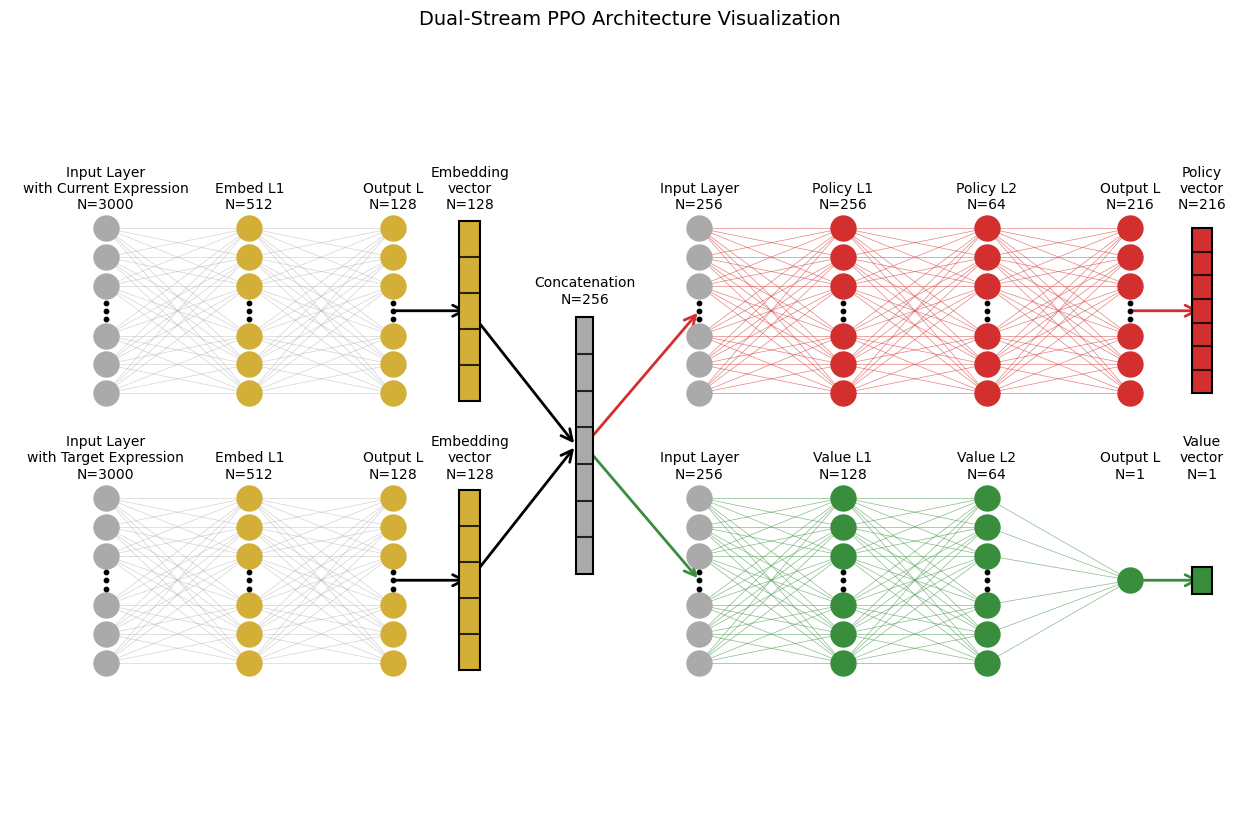

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.lines import Line2D

def visualize_ppo_final_architecture_v9(
    input_dim: int,
    embedding_dims: list,
    policy_head_dims: list,
    policy_output_dim: int,
    value_head_dims: list,
    value_output_dim: int = 1,
    max_vis_neurons: int = 6,
    neuron_radius: float = 0.09,
    figsize: tuple = (16, 10),
    save_path: str = 'ppo_architecture_visualization_final_v9.png'):
    """
    Visualizes a dual-stream PPO architecture with parallel embeddings, concatenation,
    and distinct Policy/Value heads.
    """
    LAYER_DIMS = embedding_dims
    MERGE_DIM = embedding_dims[-1] * 2

    # Colors for white background
    COLOR_BG = '#FFFFFF'
    COLOR_TEXT = '#000000'
    COLOR_ELLIPSIS = '#000000'
    
    COLOR_INPUT = '#AAAAAA'
    COLOR_EMBEDDING = '#D4AF37'
    COLOR_POLICY = '#D32F2F'
    COLOR_VALUE = '#388E3C'
    COLOR_WEIGHTS_SHARED = '#A9A9A9'
    
    # --- CHANGE 1 of 2: REVERTED TO THE PREFERRED, WIDER LAYOUT PARAMETERS ---
    Y_RANGE = 7
    X_SPACING = 1.5
    X_SPACING_EMBED_OUT = 0.8
    X_SPACING_CONCAT_IN = 1.2
    X_SPACING_CONCAT_OUT = 1.2
    X_START = 0
    Y_STREAM_SPACING = Y_RANGE * 0.7  
    CONCAT_BOX_HEIGHT = Y_RANGE * 2 / 3 
    
    Y_LABEL_OFFSET_MULTILINE = 1.8
    Y_LABEL_OFFSET_SINGLELINE = 1.7
    
    layer_coords = {}
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor(COLOR_BG)
    ax.axis('off')
    
    def draw_arrow(p1, p2, color):
        arrow = patches.FancyArrowPatch(p1, p2, arrowstyle='->', mutation_scale=20, linewidth=2.0, color=color, zorder=1)
        ax.add_patch(arrow)

    def draw_vector_box(x, box_y_center, height, color, label_y_center, label=None, dim=None, lines=0, width_multiplier=1.0):
        half_width = neuron_radius * width_multiplier
        rect = patches.Rectangle((x - half_width, box_y_center - height / 2), 2 * half_width, height, facecolor=color, edgecolor=COLOR_TEXT, linewidth=1.5, zorder=2)
        ax.add_patch(rect)
        if label and dim:
            y_offset = Y_LABEL_OFFSET_MULTILINE if "\n" in label else Y_LABEL_OFFSET_SINGLELINE
            if "Concatenation" in label:
                ax.text(x, box_y_center + height/2 + 0.2, f"{label}\nN={dim}", ha='center', va='bottom', color=COLOR_TEXT, fontsize=10)
            else:
                ax.text(x, label_y_center + y_offset, f"{label}\nN={dim}", ha='center', va='bottom', color=COLOR_TEXT, fontsize=10)

        if lines > 1:
             y_lines = np.linspace(box_y_center - height / 2, box_y_center + height / 2, lines + 2)[1:-1]
             ax.hlines(y_lines, x - half_width, x + half_width, colors=COLOR_TEXT, alpha=0.8, linewidth=1.5)
        return (x, [box_y_center], dim)
    
    def draw_layer_with_ellipsis(ax, x, y_center, dim, color, label_text):
        K = min(dim, max_vis_neurons)
        y_offset = Y_LABEL_OFFSET_MULTILINE if "\n" in label_text else Y_LABEL_OFFSET_SINGLELINE
        ax.text(x, y_center + y_offset, label_text, ha='center', va='bottom', color=COLOR_TEXT, fontsize=10)

        if K == 1 and dim == 1:
            y_coords = np.array([y_center])
            ax.scatter([x], y_coords, s=(neuron_radius * 200)**2, c=color, zorder=3)
            return y_coords

        neurons_per_side = K // 2
        gap = 0.9  
        spread = 1.5 # Reverted to the wider vertical spread
        y_coords_top = np.linspace(y_center + gap / 2, y_center + spread, neurons_per_side)
        bottom_neurons_count = K - neurons_per_side
        y_coords_bottom = np.linspace(y_center - spread, y_center - gap / 2, bottom_neurons_count)
        y_coords = np.concatenate((y_coords_bottom, y_coords_top))
        ax.scatter([x] * K, y_coords, s=(neuron_radius * 200)**2, c=color, zorder=3)

        if dim > K:
            dot_spacing = 0.15 
            ax.scatter([x] * 3, [y_center - dot_spacing, y_center, y_center + dot_spacing], s=10, c=COLOR_ELLIPSIS, zorder=3)
        return y_coords

    max_x_reached = X_START 
    
    STREAM_SPECS = {'Current Expression': 1, 'Target Expression': -1}
    stream_y_centers = {}
    
    for stream_name, multiplier in STREAM_SPECS.items():
        y_shift = Y_STREAM_SPACING / 2 * multiplier
        stream_y_centers[stream_name] = y_shift
        x_input = X_START
        label = f"Input Layer\nwith {stream_name}\nN={input_dim}"
        y_coords_input = draw_layer_with_ellipsis(ax, x_input, y_shift, input_dim, COLOR_INPUT, label)
        layer_coords[(stream_name, 0)] = (x_input, y_coords_input, input_dim)
        x_prev, prev_y = x_input, y_coords_input
        for embed_idx, dim in enumerate(LAYER_DIMS):
            layer_idx = embed_idx + 1
            x_curr = x_prev + X_SPACING
            label = f"Embed L{layer_idx}\nN={dim}"
            if embed_idx == len(LAYER_DIMS) - 1:
                label = f"Output L\nN={dim}"
            y_coords = draw_layer_with_ellipsis(ax, x_curr, y_shift, dim, COLOR_EMBEDDING, label)
            layer_coords[(stream_name, layer_idx)] = (x_curr, y_coords, dim)
            for y1 in prev_y:
                for y2 in y_coords:
                    ax.plot([x_prev, x_curr], [y1, y2], COLOR_WEIGHTS_SHARED, linewidth=0.5, alpha=0.5, zorder=1)
            x_prev, prev_y = x_curr, y_coords

    X_EMBED_OUT_VEC = x_prev + X_SPACING_EMBED_OUT
    embed_out_vec_height = CONCAT_BOX_HEIGHT * 0.7
    embed_out_vectors = {}
    for stream_name in STREAM_SPECS:
        y_shift = stream_y_centers[stream_name]
        coords = layer_coords[(stream_name, len(LAYER_DIMS))]
        x_out_draw, y_out_center, _ = draw_vector_box(X_EMBED_OUT_VEC, y_shift, embed_out_vec_height, COLOR_EMBEDDING, label_y_center=y_shift, label="Embedding\nvector", dim=128, lines=4, width_multiplier=1.2)
        embed_out_vectors[stream_name] = (x_out_draw, y_out_center)
        draw_arrow((coords[0], np.mean(coords[1])), (x_out_draw, y_out_center[0]), COLOR_TEXT)

    X_CONCAT_FINAL = X_EMBED_OUT_VEC + X_SPACING_CONCAT_IN
    x_merge, y_merge_center, merge_dim = draw_vector_box(X_CONCAT_FINAL, 0, CONCAT_BOX_HEIGHT, COLOR_INPUT, label_y_center=0, label="Concatenation", dim=MERGE_DIM, lines=6)
    layer_coords['Merge'] = (x_merge, y_merge_center, merge_dim)
    
    target_x = x_merge - neuron_radius 
    for stream_name in STREAM_SPECS:
        vec_coords = embed_out_vectors[stream_name]
        draw_arrow((vec_coords[0], vec_coords[1][0]), (target_x, y_merge_center[0]), COLOR_TEXT)
    
    X_HEAD_START = X_CONCAT_FINAL + X_SPACING_CONCAT_OUT
    head_specs = {'Policy': {'dims': policy_head_dims, 'output': policy_output_dim, 'color': COLOR_POLICY}, 'Value':  {'dims': value_head_dims, 'output': value_output_dim, 'color': COLOR_VALUE}}
    
    for head_name, spec in head_specs.items():
        y_shift = stream_y_centers['Current Expression'] if head_name == 'Policy' else stream_y_centers['Target Expression']
        x_L0 = X_HEAD_START
        y_coords_L0 = draw_layer_with_ellipsis(ax, x_L0, y_shift, MERGE_DIM, COLOR_INPUT, f"Input Layer\nN={MERGE_DIM}")
        
        # --- CHANGE 2 of 2: REVERTED ARROW TARGET TO THE CENTER OF THE LAYER (THE DOTS) ---
        target_y = np.mean(y_coords_L0)
        draw_arrow((x_merge, y_merge_center[0]), (x_L0, target_y), spec['color'])
        
        x_prev, prev_y = x_L0, y_coords_L0
        
        for head_idx, dim in enumerate(spec['dims']):
            x_curr = x_prev + X_SPACING
            label = f"{head_name} L{head_idx+1}\nN={dim}"
            y_coords = draw_layer_with_ellipsis(ax, x_curr, y_shift, dim, spec['color'], label)
            for y1 in prev_y:
                for y2 in y_coords:
                    ax.plot([x_prev, x_curr], [y1, y2], color=spec['color'], linewidth=0.5, alpha=0.6, zorder=1)
            x_prev, prev_y = x_curr, y_coords
        
        dim = spec['output']
        x_out_layer = x_prev + X_SPACING
        label_out = f"Output L\nN={dim}"
        y_coords_out = draw_layer_with_ellipsis(ax, x_out_layer, y_shift, dim, spec['color'], label_out)
        for y1 in prev_y:
            for y2 in y_coords_out:
                 ax.plot([x_prev, x_out_layer], [y1, y2], color=spec['color'], linewidth=0.5, alpha=0.6, zorder=1)
        
        x_out_vector = x_out_layer + X_SPACING * 0.5 
        output_height = 0.5 if (head_name == 'Value' and dim == 1) else 3.0
        output_lines = 1 if (head_name == 'Value' and dim == 1) else min(dim, 6)
        x_out_draw, y_out_center, _ = draw_vector_box(x_out_vector, y_shift, output_height, spec['color'], label_y_center=y_shift, label=f"{head_name}\nvector", dim=dim, lines=output_lines, width_multiplier=1.2)
        draw_arrow((x_out_layer, np.mean(y_coords_out)), (x_out_draw, y_out_center[0]), spec['color'])
        max_x_reached = max(max_x_reached, x_out_vector) 
                
    ax.set_title("Dual-Stream PPO Architecture Visualization", color=COLOR_TEXT, fontsize=14)
    ax.set_xlim(X_START - 1.0, max_x_reached + 0.5)
    ax.set_ylim(-Y_RANGE / 2 - 3, Y_RANGE / 2 + 4)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor=COLOR_BG)
    print(f"Visualization saved to: {save_path}")
    plt.show()

# --- Calling the function ---
INPUT_DIM = 3000
EMBEDDING_LAYERS = [512, 128]
POLICY_HEAD_LAYERS = [256, 64]
POLICY_ACTION_SPACE = 216
VALUE_HEAD_LAYERS = [128, 64]
VALUE_OUTPUT = 1

visualize_ppo_final_architecture_v9(
    input_dim=INPUT_DIM,
    embedding_dims=EMBEDDING_LAYERS,
    policy_head_dims=POLICY_HEAD_LAYERS,
    policy_output_dim=POLICY_ACTION_SPACE,
    value_head_dims=VALUE_HEAD_LAYERS,
    value_output_dim=VALUE_OUTPUT,
    max_vis_neurons=6,
    save_path='ppo_architecture_final_layout.png'
)